# Instacart Market Basket Analysis

In [82]:
#https://www.kaggle.com/c/instacart-market-basket-analysis

## Import libraries

In [83]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
color = sns.color_palette()

%matplotlib inline

In [84]:
ls

aisles.csv                 order_products__train.csv
departments.csv            orders.csv
instacart.ipynb            products.csv
order_products__prior.csv  sample_submission.csv


Lets read our tables into dataframes

In [85]:
aisles_df = pd.read_csv('aisles.csv')
departments_df = pd.read_csv('departments.csv')
order_products_prior_df = pd.read_csv('order_products__prior.csv')
order_products_train_df = pd.read_csv('order_products__train.csv')
orders_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')

In [86]:
orders_df.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [87]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [88]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


As we can see, it looks like orders_df should contain both the orders in the prior and train dfs. Theres this interesting column eval_set in orders_df that might explain the distribution.

In [89]:
orders_df.groupby('eval_set')['user_id'].nunique()

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

Looks like in total we have 206,209 users, 131,209 in the training set, and 75,000 that we need to predict.

In [90]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Lets do some explorator analysis on this dataframe

Up first, lets see the order distribution among days of the week.

## Orders analysis

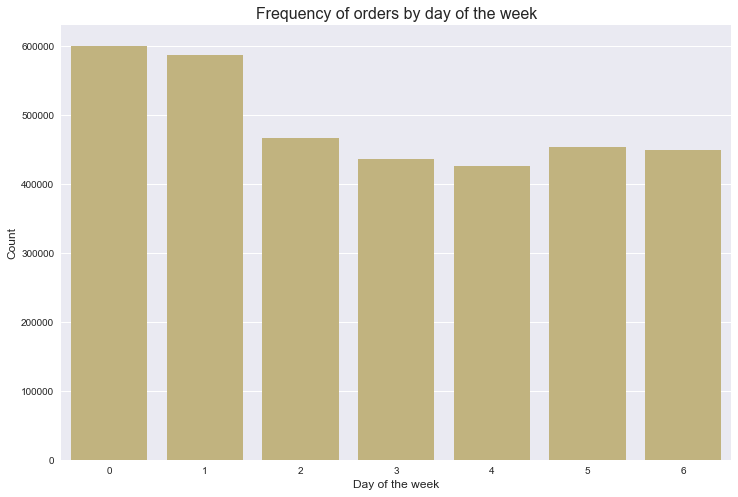

In [91]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders_df, color=color[4])
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Frequency of orders by day of the week', fontsize=16)
plt.show()

Looks like most of the orders are performed on the weekend, Saturday being 0, and Sunday 1.

Next, lets look at the distribution of orders during the different hours of the day.

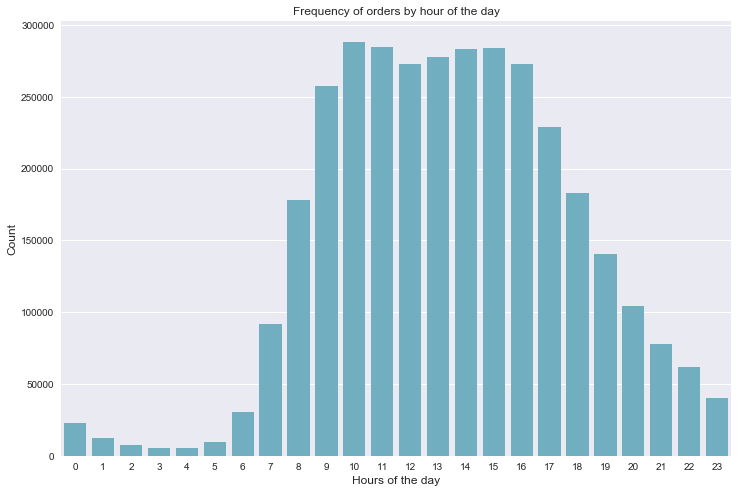

In [92]:
plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day',data=orders_df,color=color[5])
plt.ylabel('Count',fontsize=12)
plt.xlabel('Hours of the day',fontsize=12)
plt.title('Frequency of orders by hour of the day')
plt.show()

Looks like throughout the day, orders seem to be congested between the morning and early evening hours.

Lets see the distribution of the number of days between each order.

In [93]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

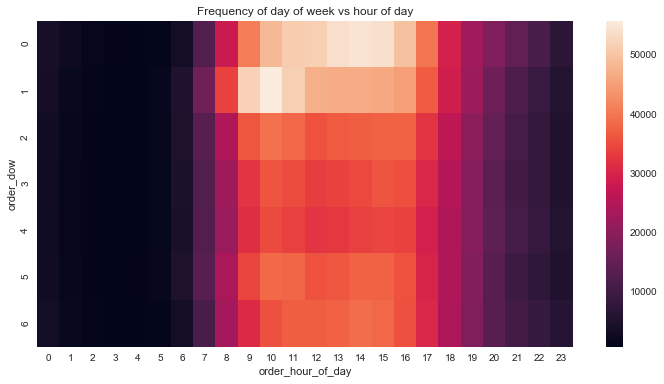

In [94]:
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Frequency of day of week vs hour of day')
plt.show()

Looks like most orders are placed in the afternoon/evening on Saturday, and morning for Sunday.

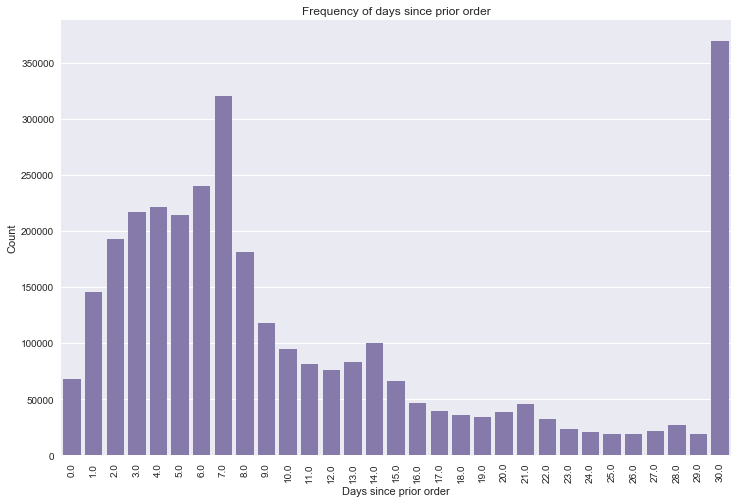

In [95]:
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order',data=orders_df,color=color[3])
plt.ylabel('Count')
plt.xlabel('Days since prior order')
plt.xticks(rotation='vertical')
plt.title('Frequency of days since prior order')
plt.show()

Looks like the two biggest peaks are at 7 days (week end) and 30 days (however, we must be careful wth this because any order that is made over 30 days since the prior order, will be categorized as 30 days, so its best to ignore this). There seem to also be smaller peaks at 14 days and 21 days. Together, that tells me that the orders seem to peak at the end of the weeks. 

The largest cluster of orders seems to be within the first week, indicating that people seem to buy the largest amount in that first week, and then perhaps re-up in smaller quantities at the end of weeks.

Now lets examine the class balance of the prior and train sets. This is also the average percentage of products in an order that are reordered products.

In [96]:
order_products_prior_df['reordered'].mean()

0.5896974667922161

In [97]:
order_products_train_df['reordered'].mean()

0.5985944127509629

Looks about equal, right about 59-60%. Not too imbalanced either.

In [98]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.groupby('reordered').aggregate('count') / grouped_df.shape[0]

,order_id
reordered,
0,0.120849
1,0.879151


In [99]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.groupby('reordered').aggregate('count') / grouped_df.shape[0]

,order_id
reordered,
0,0.06556
1,0.93444


It seems that around 12% (prior df) and 6% (train df) of orders have no reordered items.

Lets see the distribution of products bought in each order, to understand normally how many products someone purchases per order.

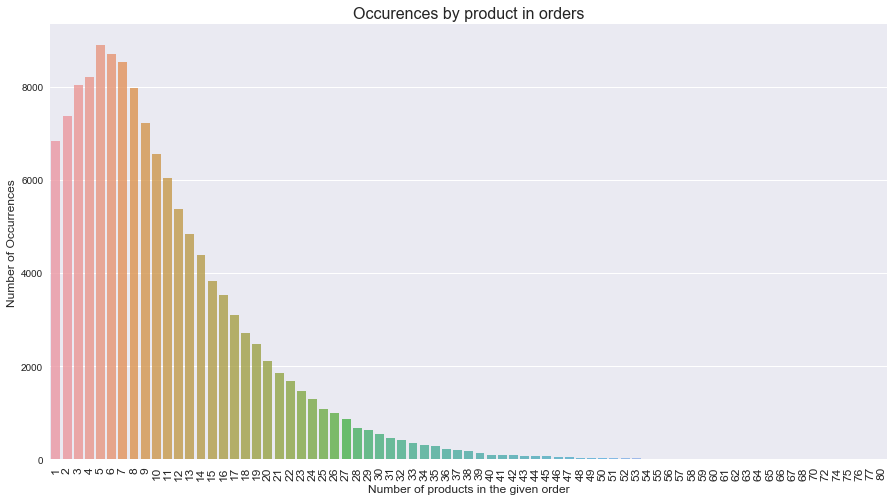

In [100]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()

plt.figure(figsize=(15,8))
sns.countplot('add_to_cart_order', data=grouped_df, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical', fontsize=12)
plt.title('Occurences by product in orders', fontsize=16)
plt.show()

In [101]:
grouped_df['add_to_cart_order'].value_counts().head()

5    8895
6    8708
7    8541
4    8218
3    8033
Name: add_to_cart_order, dtype: int64

Right tailed distribution, max value at 5.

It looks like people mostly order 5 products per order.

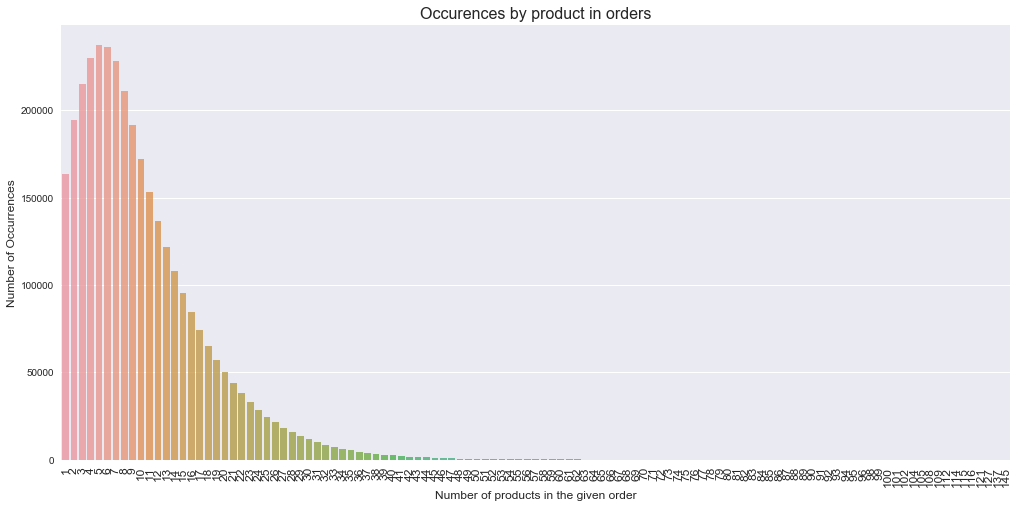

In [102]:
orders_concat = pd.concat((order_products_prior_df,order_products_train_df))
grouped_concat = orders_concat.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()

plt.figure(figsize=(17,8))
sns.countplot('add_to_cart_order', data=grouped_concat, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical', fontsize=12)
plt.title('Occurences by product in orders', fontsize=16)
plt.show()

Same thing for all the orders.

Lets take a look at the other tables.

In [103]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [104]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [105]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [106]:
orders_concat.head(10) #just to remind myself whats in the df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


It looks like we can merge all these tables together, and get a better idea of the frequency of popular products, aisles, and departments.

In [107]:
orders_concat = pd.merge(orders_concat, products_df, on='product_id', how='left')
orders_concat = pd.merge(orders_concat, aisles_df, on='aisle_id', how='left')
orders_concat = pd.merge(orders_concat, departments_df, on='department_id', how='left')
orders_concat.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [108]:
cnt_srs = orders_concat['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name','frequency']
cnt_srs

,product_name,frequency
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877
5,Organic Avocado,184224
6,Large Lemon,160792
7,Strawberries,149445
8,Limes,146660
9,Organic Whole Milk,142813


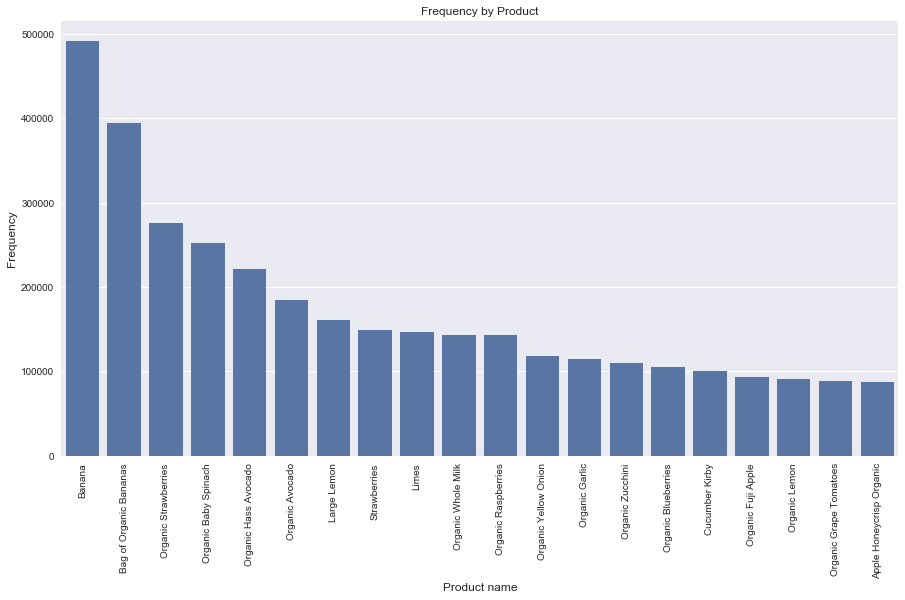

In [109]:
plt.figure(figsize=(15,8))
sns.barplot(cnt_srs['product_name'], cnt_srs['frequency'], color = color[0])
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Product name', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency by Product')
plt.show()

Fruits and veggies look like they dominate the products bought. Furthermore, organic fruits and veggies are a significant chunk of this.

Lets look at aisles.

In [110]:
cnt_srs = orders_concat['aisle'].value_counts().reset_index().head(20)
cnt_srs.columns = ['aisle','frequency']
cnt_srs

,aisle,frequency
0,fresh fruits,3792661
1,fresh vegetables,3568630
2,packaged vegetables fruits,1843806
3,yogurt,1507583
4,packaged cheese,1021462
5,milk,923659
6,water seltzer sparkling water,878150
7,chips pretzels,753739
8,soy lactosefree,664493
9,bread,608469


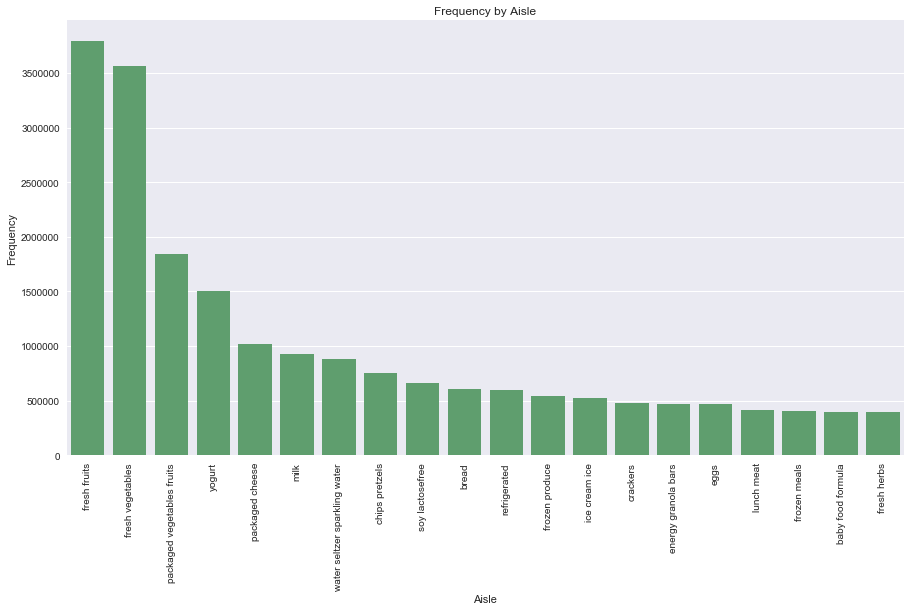

In [111]:
plt.figure(figsize=(15,8))
sns.barplot(cnt_srs['aisle'], cnt_srs['frequency'], color=color[1])
plt.ylabel('Frequency')
plt.xlabel('Aisle')
plt.title('Frequency by Aisle')
plt.xticks(rotation='vertical')
plt.show()

We can see that the popular aisles correlate with the popular products from above. The 2 most popular aisles are fresh fruits and veggies, correlating with the most popular products which were in the realms of fruits and veggies.

Lets look at departments.

In [112]:
cnt_srs = orders_concat['department'].value_counts().reset_index().head(20)
cnt_srs.columns = ['department','frequency']
cnt_srs

,department,frequency
0,produce,9888378
1,dairy eggs,5631067
2,snacks,3006412
3,beverages,2804175
4,frozen,2336858
5,pantry,1956819
6,bakery,1225181
7,canned goods,1114857
8,deli,1095540
9,dry goods pasta,905340


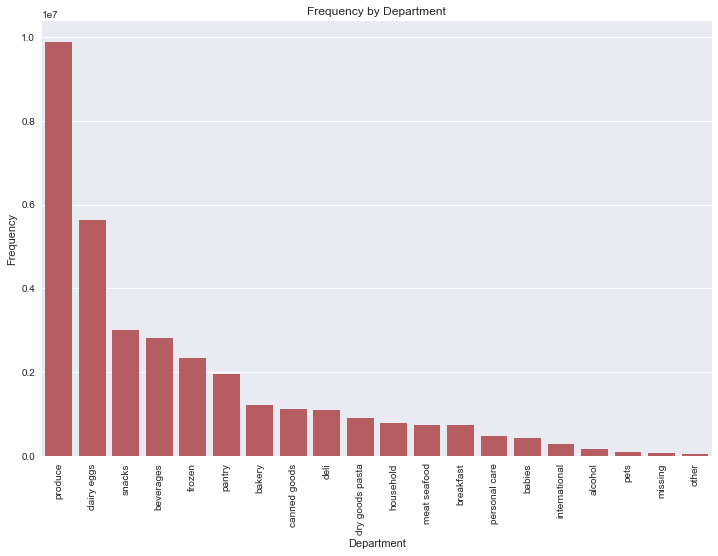

In [113]:
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs['department'], cnt_srs['frequency'], color=color[2])
plt.ylabel('Frequency')
plt.xlabel('Department')
plt.title('Frequency by Department')
plt.xticks(rotation = 'vertical')
plt.show()

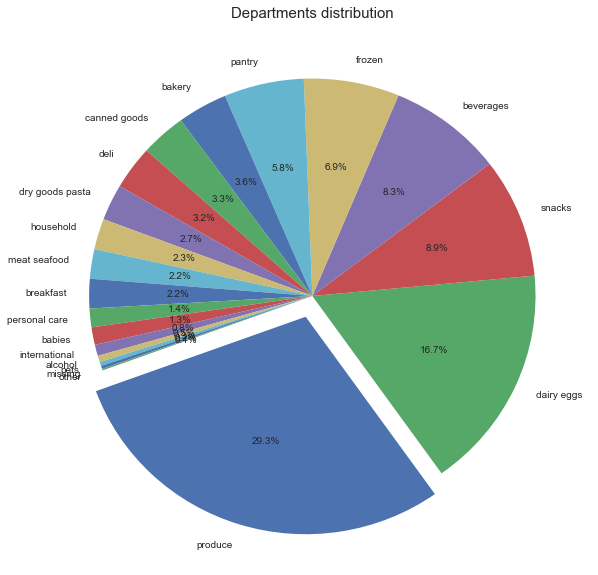

In [148]:
explode = np.append([.1],[[0]*(len(cnt_srs.department)-1)])
plt.figure(figsize=(10,10))
labels = (np.array(cnt_srs.department))
sizes = (np.array((cnt_srs.frequency / cnt_srs.frequency.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200, explode = explode)
plt.title("Departments distribution", fontsize=15)
plt.show()

The distribution of departments also makes sense with the information we saw before. Produce is the largest department.

In [149]:
#function that will make all these charts in one shot
viz_cols  = ['product_name','aisle','department']
def viz_orders(df, cols):
    for i, col in enumerate(cols):
        cnt_srs = df[col].value_counts().reset_index().head(20)
        cnt_srs.columns = [col, 'frequency']
        plt.figure(figsize=(12,8))
        sns.barplot(cnt_srs[col], cnt_srs['frequency'], color=color[i])
        plt.ylabel('Frequency')
        plt.xlabel(col)
        plt.title('Frequency by ' + col)
        plt.xticks(rotation='vertical')
        plt.show()

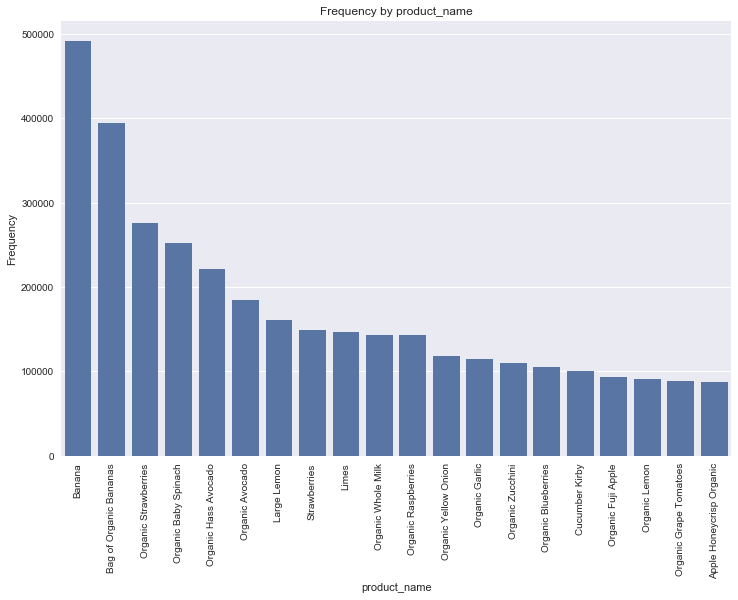

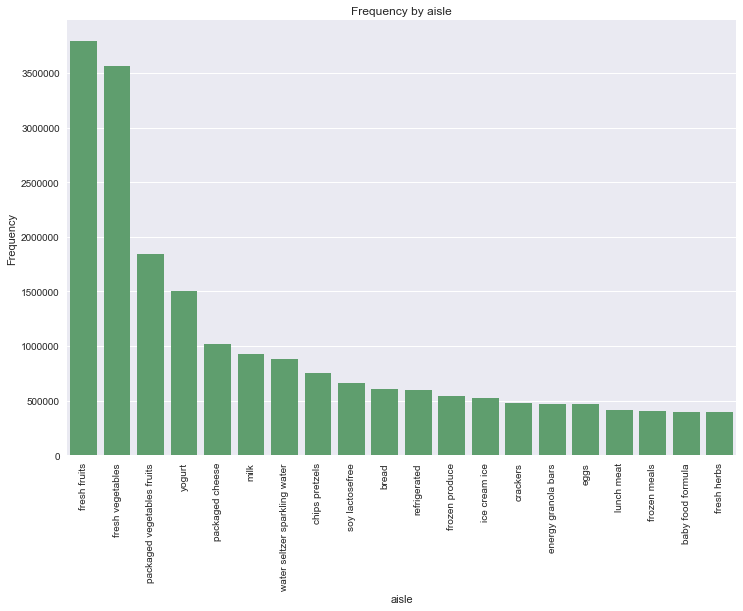

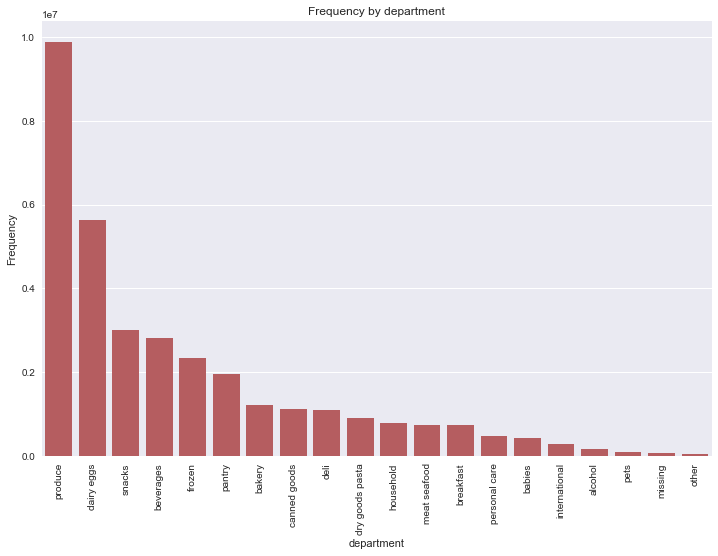

In [150]:
viz_orders(orders_concat, viz_cols)

Since were looking to predict which products will be reordered in a users next order, lets see what patterns we can find in relation to the reordered feature.

## Reorder ratio analysis

Considering our goals is to predict reorders, analysis that gives us an understanding of which feature and parameters historically showed better reorder ratios is really the "meat" of what were looking to understand.

In [151]:
orders_concat.sort_values('order_id').head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
32434489,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
32434491,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
32434492,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
32434493,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
32434494,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce


In [152]:
orders_df.sort_values('order_id').head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0


In [153]:
orders_concat = pd.merge(orders_concat, orders_df, on='order_id', how='left')
orders_concat.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [154]:
grouped_df = orders_concat.groupby('department')['reordered'].aggregate('mean').reset_index()
grouped_df = grouped_df.sort_values('reordered', ascending=False)
grouped_df

,department,reordered
7,dairy eggs,0.670161
3,beverages,0.653651
19,produce,0.650521
2,bakery,0.628381
8,deli,0.608130
18,pets,0.602557
1,babies,0.577680
5,bulk,0.577090
20,snacks,0.574464
0,alcohol,0.571221


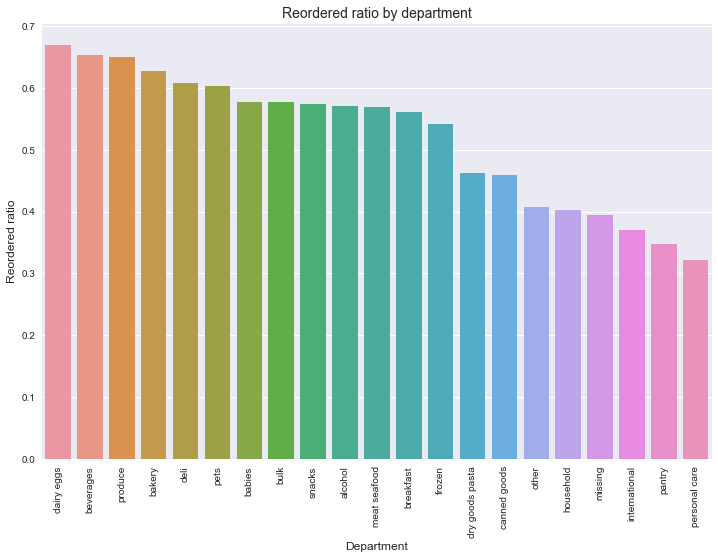

In [155]:
plt.subplots(figsize=(12,8))
sns.barplot(grouped_df['department'], grouped_df['reordered'], color = color[5])
plt.xlabel('Department', fontsize=12)
plt.ylabel('Reordered ratio', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Reordered ratio by department', fontsize=14)
plt.show()

Dairy and eggs has the highest reordered ratio, while personal care has the worst.

In [160]:
grouped_df = orders_concat.groupby('aisle')['reordered'].aggregate('mean').reset_index().head(20)
grouped_df = grouped_df.sort_values('reordered', ascending=False)
grouped_df

,aisle,reordered
11,bread,0.670552
12,breakfast bakery,0.651302
14,bulk dried fruits vegetables,0.619798
4,baby food formula,0.589005
13,breakfast bars pastries,0.586742
17,butter,0.577084
18,candy chocolate,0.572986
9,beers coolers,0.566916
19,canned fruit applesauce,0.562971
2,baby accessories,0.551500


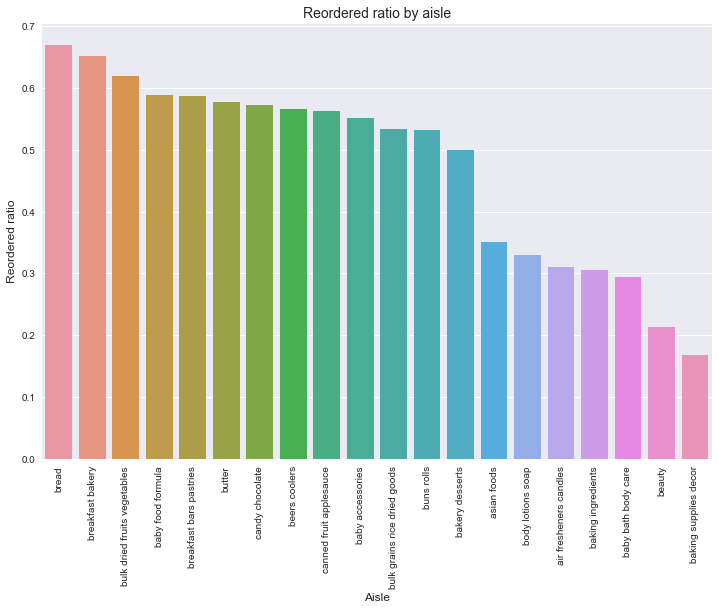

In [161]:
plt.subplots(figsize=(12,8))
sns.barplot(grouped_df['aisle'], grouped_df['reordered'], color = color[6])
plt.xlabel('Aisle', fontsize=12)
plt.ylabel('Reordered ratio', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Reordered ratio by aisle', fontsize=14)
plt.show()

Breat has the highest reordered ration, while baking supplies decor has the lowest.

In [169]:
orders_concat_mod = orders_concat.copy()
orders_concat_mod['add_to_cart_order'].loc[orders_concat_mod['add_to_cart_order'] > 70] = 70

grouped_df = orders_concat_mod.groupby('add_to_cart_order')['reordered'].aggregate('mean').reset_index()
grouped_df.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,add_to_cart_order,reordered
0,1,0.679302
1,2,0.677135
2,3,0.658426
3,4,0.637350
4,5,0.617598


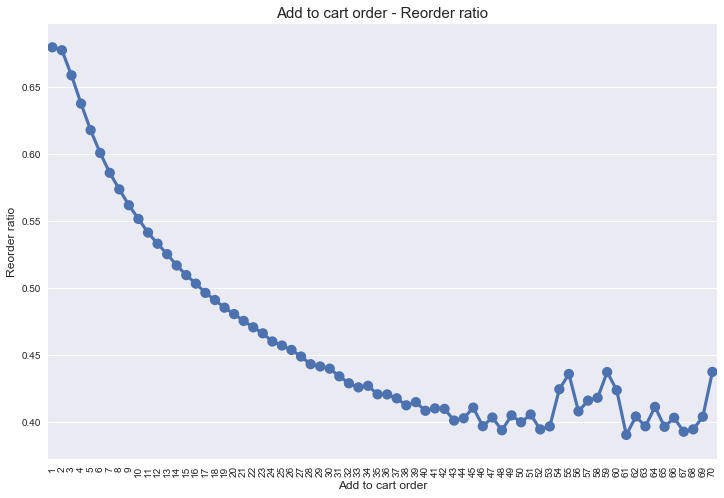

In [170]:
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order'],grouped_df['reordered'])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

From the above chart, we can tell that the products which are ordered first, are more likely to be reordered. We can make sense of this by thinking about the way that people typically shop - we will typically buy what we know we need at first, and thats non-negotiable, and then we might browse and add some non-necessities. So, this makes sense.

Lets look at the relationship between the time-based features, and the reorder feature.

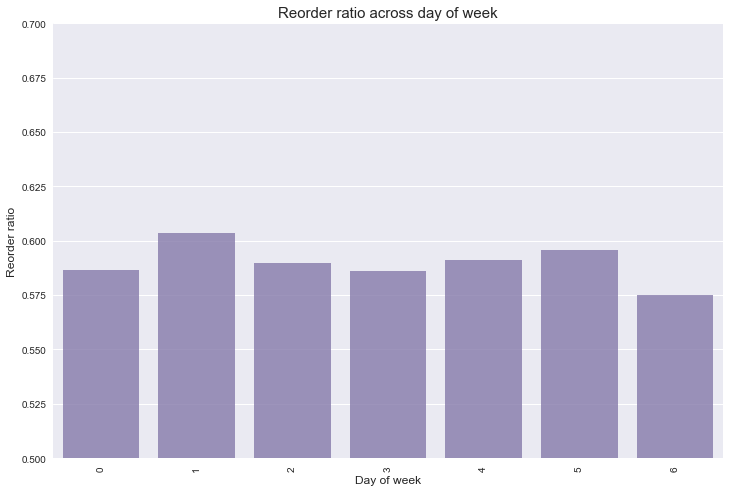

In [179]:
grouped_df = orders_concat.groupby("order_dow")["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'], grouped_df['reordered'], alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

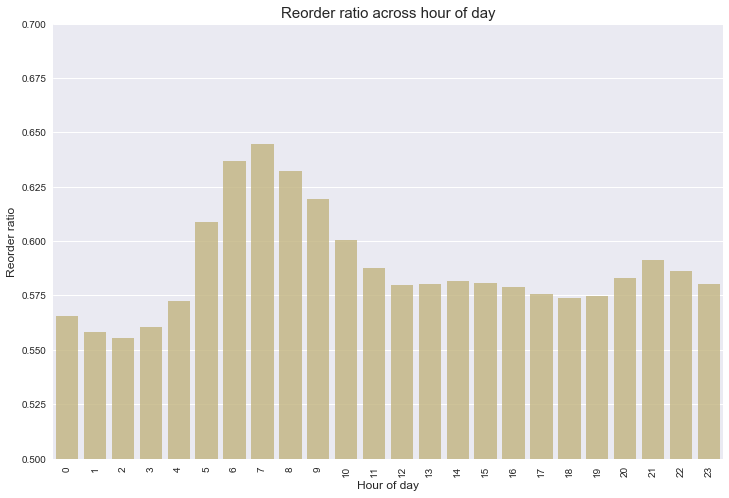

In [180]:
grouped_df = orders_concat.groupby("order_hour_of_day")["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'], grouped_df['reordered'], alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

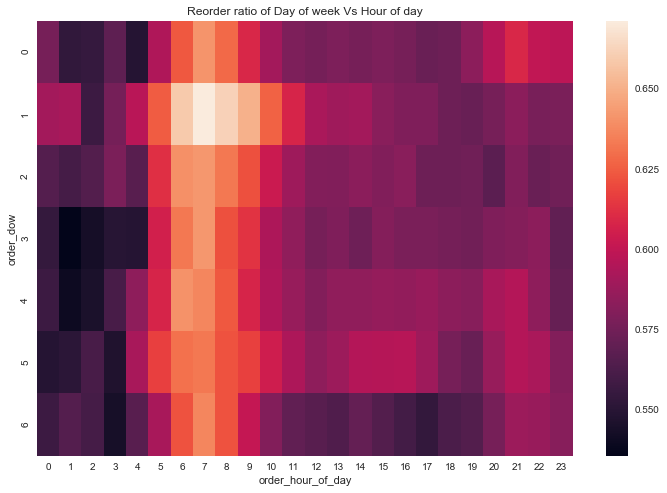

In [181]:
grouped_df = orders_concat.groupby(['order_dow','order_hour_of_day'])['reordered'].aggregate('mean').reset_index()

grouped_df = grouped_df.pivot('order_dow','order_hour_of_day','reordered')
plt.figure(figsize=(12,8))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

So, it looks like the most reorders come on a Sunday morning.

Typically, it seems that morning have a higher reorder volume than afternoons and late evenings.